In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import datetime

import xesmf as xe
import scipy.signal as signal
import scipy.stats as st
import xgcm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib as mpl
import cartopy.crs as ccrs
import cmocean
import cmaps

from glob import glob
import sys
sys.path.append('../')
from utils import *
from load import *
from numerics import *
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=10, threads_per_worker=1)
client  = Client(cluster, asynchronous=True)
client


2023-07-06 11:13:29,296 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-c3lu45wm', purging
2023-07-06 11:13:29,296 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-2axbebsx', purging
2023-07-06 11:13:29,296 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-zp5kg3_8', purging
2023-07-06 11:13:29,296 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-_6xuutud', purging
2023-07-06 11:13:29,297 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-_4rl_ke7', purging
2023-07-06 11:13:29,297 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-dgwzum66', purging
2023-07-06 11:13:29,297 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-do9hwxrr', purging

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 10,Total memory: 93.09 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36181,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 93.09 GiB
Comm: tcp://127.0.0.1:41515,Total threads: 1
Dashboard: http://127.0.0.1:43671/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:38635,


In [3]:
# sealevel = xr.open_mfdataset('/home/lucasg/storage/SEQUIA/DESALADORAS_RUND1/control/crocod1_avg_Y2001M1.nc', preprocess=lambda ds: ds.zeta)
# sealevel = sealevel.load()

In [49]:
dummy = xr.open_dataset('/home/lucasg/storage/SEQUIA/DESALADORAS_RUND1/control/crocod1_avg_Y2001M1.nc')
hc, Cs_r, s_rho = dummy.hc, dummy.Cs_r, dummy.s_rho
del dummy

def preprocess_1(ds):
    ds = fix_crocotime(ds, YORIG='1949-12-30 23:59:50')
    print(ds.time.values[0])
    print('loading and masking data')
    ds = center_crocogrid(ds[['u','v','h','zeta','mask_rho']],['u','v','h','zeta','mask_rho'])
    ds = ds.isel(eta_rho=slice(1,-1)).load()
    # ds = ds.isel(eta_rho=slice(1,-1)).isel(xi_rho=slice(1,-1)).dropna('eta_rho').dropna('xi_rho').load()
    ds = ds.where(ds.mask_rho==1).load()
    return ds

def preprocess_2(ds):
    print('getting coastal pixels')
    coast = []
    for e in np.arange(len(ds.eta_rho)):
        x = ds.isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=slice(-7,-1)) 
        x.coords['xi_rho'] = ('xi_rho', np.arange(len(x.xi_rho)))
        coast.append(x)
    coast = xr.concat(coast, 'eta_rho')
    return coast

def preprocess_3(ds, s_rho=s_rho, hc=hc, Cs_r=Cs_r):
    print('interpolate sigma to Z')
    target_depths = np.arange(0,30+0.25,0.25)
    zcontrol_coast = rhopoints_depths(ds.h.expand_dims(dim={'s_rho':s_rho}), ds.zeta, s_rho, Cs_r, hc).load()
    zcontrol_coast.name = 'z_rho'
    # zcontrol_coast.coords['lon_rho'] = ds.lon_rho

    husk = xgcm.Grid(ds, coords={'z':{'center':'s_rho'}}, periodic=False)
    u = husk.transform(ds.u,'z',-target_depths, target_data=zcontrol_coast, method='linear', mask_edges=False)
    v = husk.transform(ds.v,'z',-target_depths, target_data=zcontrol_coast, method='linear', mask_edges=False)
    ds = xr.merge([u,v,ds.h, ds.zeta, ds.mask_rho])
    return ds

def preprocess(ds):
    ds = preprocess_1(ds)
    ds = preprocess_2(ds)
    ds = preprocess_3(ds)
    return ds.mean('xi_rho')

gridd1 = xr.open_dataset('~/storage/SEQUIA/crocod1_grd.nc').load()
control = []
for yr in range(2001,2005+1):
    for m in range(1,12+1):
        try:
            x = xr.open_mfdataset('data/coastalpixels/coastalpixels_avg_Y{}M{}.nc'.format(yr,m))
        except:
            pass
            # pathsavg_control = sorted(glob('/home/lucasg/storage/SEQUIA/DESALADORAS_RUND1/control/crocod1_avg_Y{}M{}.nc'.format(yr,m)))
            # x          = xr.open_mfdataset(pathsavg_control, preprocess=preprocess)
            # x.to_netcdf('data/coastalband_avg_Y{}M{}.nc'.format(yr,m), mode='w')
        control.append(x.sortby('time'))
control = xr.concat(control, 'time')


In [50]:
dummy = xr.open_dataset('/home/lucasg/storage/SEQUIA/DESALADORAS_RUND1/control/crocod1_avg_Y2001M1.nc')
hc, Cs_r, s_rho = dummy.hc, dummy.Cs_r, dummy.s_rho
del dummy

def preprocess_1(ds, mask_rho=gridd1.mask_rho==1):
    ds = fix_crocotime(ds, YORIG='1949-12-30 23:59:50')
    print(ds.time.values[0])
    print('loading and masking data')
    ds = ds[['salt_xadv','salt_yadv','salt_vadv']]
    ds = ds.where(mask_rho==1).load()
    ds = ds.isel(eta_rho=slice(1,-1)).load()
    # ds = ds.salt_xadv+ds.salt_yadv+ds.salt_vadv
    # ds = ds.salt_xadv
    # ds = ds.to_dataset(name='salt_netadv')
    # ds = ds.isel(eta_rho=slice(1,-1)).isel(xi_rho=slice(1,-1)).dropna('eta_rho').dropna('xi_rho').load()

    return ds

def preprocess_2(ds):
    print('getting coastal pixels')
    coast = []
    for e in np.arange(len(ds.eta_rho)):
        x = ds.isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=slice(-7,-1)) 
        x.coords['xi_rho'] = ('xi_rho', np.arange(len(x.xi_rho)))
        coast.append(x)
    coast = xr.concat(coast, 'eta_rho')
    return coast

def preprocess_3(ds, s_rho=s_rho, hc=hc, Cs_r=Cs_r, h=control.h, zeta=control.zeta):
    print('interpolate sigma to Z')
    target_depths = np.arange(0,30+0.25,0.25)
    zcontrol_coast = rhopoints_depths(h.expand_dims(dim={'s_rho':s_rho}), zeta, s_rho, Cs_r, hc).load()
    zcontrol_coast.name = 'z_rho'
    # zcontrol_coast.coords['lon_rho'] = ds.lon_rho
    ds=ds.reindex({'time':zcontrol_coast.time}, method='nearest')

    husk = xgcm.Grid(ds, coords={'z':{'center':'s_rho'}}, periodic=False)
    xadv = husk.transform(ds.salt_xadv,'z',-target_depths, target_data=zcontrol_coast, method='linear', mask_edges=False)
    yadv = husk.transform(ds.salt_yadv,'z',-target_depths, target_data=zcontrol_coast, method='linear', mask_edges=False)
    vadv = husk.transform(ds.salt_vadv,'z',-target_depths, target_data=zcontrol_coast, method='linear', mask_edges=False)
    ds = xr.merge([xadv,yadv,vadv])
    return ds

def preprocess(ds):
    ds = preprocess_1(ds)
    ds = preprocess_2(ds)
    ds = preprocess_3(ds)
    return ds.mean('xi_rho')

gridd1 = xr.open_dataset('~/storage/SEQUIA/crocod1_grd.nc').load()
diags = []
for yr in range(2001,2005+1):
    for m in range(1,12+1):
        try:
            x = xr.open_mfdataset('data/coastalpixels/coastalpixels_dia_Y{}M{}.nc'.format(yr,m))
        except:
            pass
            pathsavg_control = sorted(glob('/home/lucasg/storage/SEQUIA/DESALADORAS_RUND1/control/crocod1_dia_Y{}M{}.nc'.format(yr,m)))
            # x          = xr.open_mfdataset(pathsavg_control, preprocess=preprocess)
            # x = x.sel(time='{}-{}'.format(yr,m))
            # x.to_netcdf('data/coastalband_dia_Y{}M{}.nc'.format(yr,m), mode='w')
        diags.append(x.sortby('time'))
diags = xr.concat(diags, 'time')


In [51]:
control = xr.merge([control,diags]).load()
control.coords['lat_rho'] = ('eta_rho', gridd1.lat_rho.isel(xi_rho=-1)[1:-1].values)

---

In [52]:
cs_mean = np.hypot(control.u, control.v).mean('time').swap_dims({'eta_rho':'lat_rho'})
cs_std  = np.hypot(control.u, control.v).std('time').swap_dims({'eta_rho':'lat_rho'})

In [55]:
cs_mean

<xarray.DataArray 'u' (lat_rho: 564, z_rho: 121)>
array([[0.05754788, 0.05696912, 0.05268421, ..., 0.01106323, 0.01106323,
        0.01106323],
       [0.05816129, 0.05759526, 0.05338653, ..., 0.00987097, 0.00987097,
        0.00987097],
       [0.02592678, 0.02600819, 0.02670317, ..., 0.00756983, 0.00756983,
        0.00756983],
       ...,
       [0.05389071, 0.05317762, 0.050291  , ..., 0.00752912, 0.00752912,
        0.00752912],
       [0.05246037, 0.05175399, 0.0489299 , ..., 0.00662977, 0.00662977,
        0.00662977],
       [0.05061706, 0.04993074, 0.04720871, ..., 0.00722147, 0.00722147,
        0.00722147]])
Coordinates:
    xi_rho   (lat_rho) float64 113.0 113.0 114.0 114.0 ... 145.0 145.0 145.0
    eta_rho  (lat_rho) float64 2.0 3.0 4.0 5.0 6.0 ... 562.0 563.0 564.0 565.0
    lon_rho  (lat_rho) float32 288.5 288.5 288.5 288.5 ... 288.8 288.8 288.8
  * lat_rho  (lat_rho) float64 -32.69 -32.68 -32.68 ... -28.22 -28.21 -28.2
  * z_rho    (z_rho) float64 -0.0 -0.25 -0.5 -0.75 ... -29.25 -29.5 -29.75 -30.0

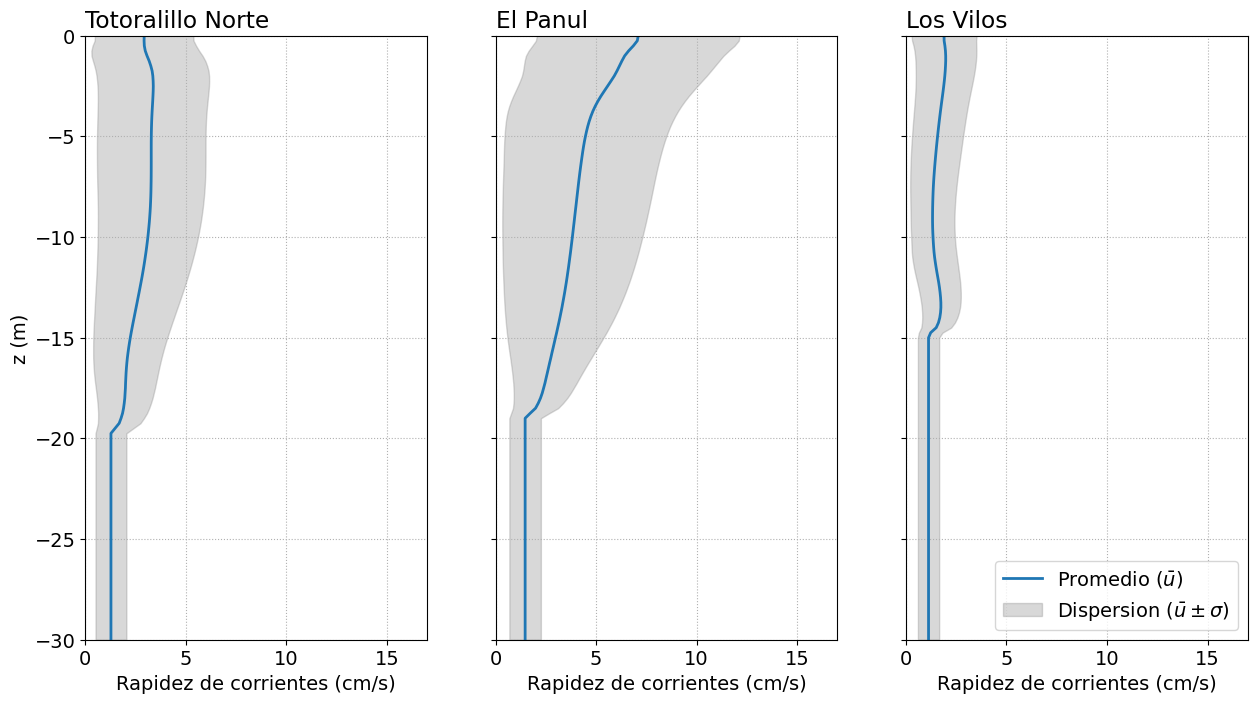

In [56]:
zones={'Totoralillo Norte':-29.49,
       'El Panul':-30.025,
       'Los Vilos':-31.90}
plt.rc('font', size=14)

fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,8), facecolor='w', dpi=100)
for i,z in enumerate(zones):
    x=cs_mean.sel(lat_rho=zones[z], method='nearest')
    y=cs_std.sel(lat_rho=zones[z], method='nearest')
    ax[i].set_title(list(zones.keys())[i], loc='left')
    ax[i].plot(x.values*100,x.z_rho, lw=2, label=r'Promedio ($\bar{u})$')
    ax[i].fill_betweenx(y.z_rho,(x.values+y.values)*100, (x.values-y.values)*100, color='grey', alpha=0.3,label=r'Dispersion ($\bar{u} \pm \sigma$)')
    ax[i].set_ylim(-30,0)
    ax[i].set_xlim(0,17)
    ax[i].set_xlabel('Rapidez de corrientes (cm/s)')
    ax[i].grid(True, ls=":")
ax[0].set_ylabel('z (m)')
ax[-1].legend(loc='lower right')

Text(0.5, 0, 'Rapidez de corrientes (cm/s)')

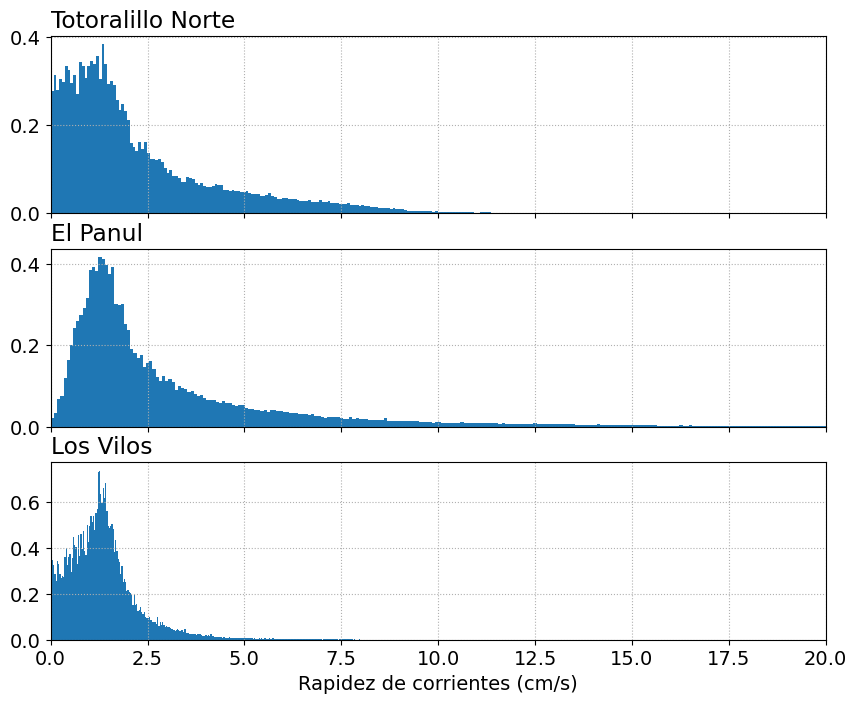

In [60]:
x = np.hypot(control.u, control.v).swap_dims({'eta_rho':'lat_rho'})*100
fig, ax = plt.subplots(3,1, sharex=True, figsize=(10,8), facecolor='w', dpi=100)
for i,z in enumerate(zones):
    x.sel(lat_rho=zones[z], method='nearest').plot.hist(density=True, ax=ax[i], bins='auto');
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title('')
    ax[i].set_title(list(zones.keys())[i], loc='left')
    ax[i].grid(True,ls=":")
ax[-1].set_xlim(0,20)
ax[-1].set_xlabel('Rapidez de corrientes (cm/s)')
# np.hypot(control.u, control.v).swap_dims({'eta_rho':'lat_rho'}).sel(lat_rho=zones['El Panul']).mean('lat_rho').plot.hist(density=True)

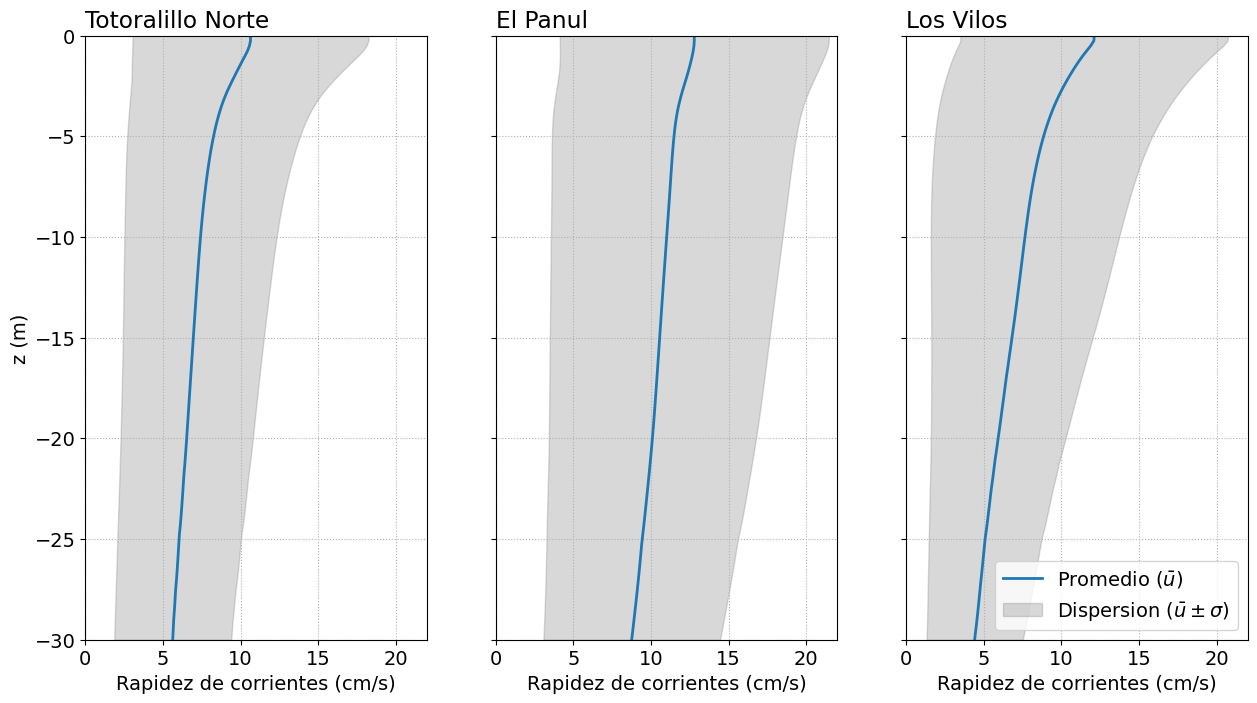

In [47]:
zones={'Totoralillo Norte':slice(-29.494, -29.467),
       'El Panul':slice(-30.035,-30.002),
       'Los Vilos':slice(-31.91,-31.85)}
plt.rc('font', size=14)


fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,8), facecolor='w', dpi=100)
for i,z in enumerate(zones):
    x=cs_mean.sel(lat_rho=zones[z]).mean('lat_rho')
    y=cs_std.sel(lat_rho=zones[z]).mean('lat_rho')
    ax[i].set_title(list(zones.keys())[i], loc='left')
    ax[i].plot(x.values*100,x.z_rho, lw=2, label=r'Promedio ($\bar{u})$')
    ax[i].fill_betweenx(y.z_rho,(x.values+y.values)*100, (x.values-y.values)*100, color='grey', alpha=0.3,label=r'Dispersion ($\bar{u} \pm \sigma$)')
    ax[i].set_ylim(-30,0)
    ax[i].set_xlim(0,22)
    ax[i].set_xlabel('Rapidez de corrientes (cm/s)')
    ax[i].grid(True, ls=":")
ax[0].set_ylabel('z (m)')
ax[-1].legend(loc='lower right')

Text(0.5, 0, 'Rapidez de corrientes (cm/s)')

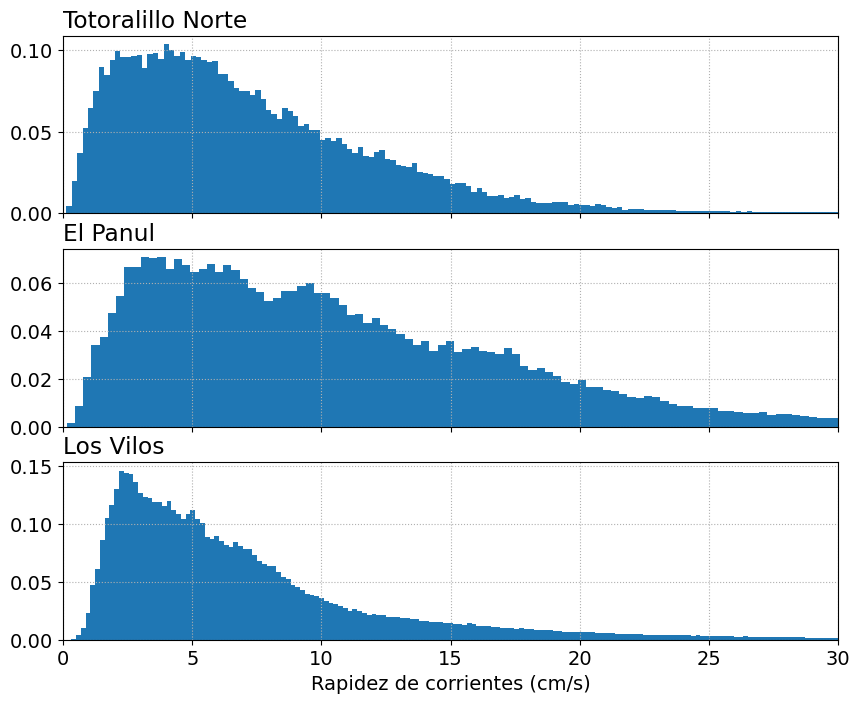

In [48]:
x = np.hypot(control.u, control.v).swap_dims({'eta_rho':'lat_rho'})*100
fig, ax = plt.subplots(3,1, sharex=True, figsize=(10,8), facecolor='w', dpi=100)
for i,z in enumerate(zones):
    x.sel(lat_rho=zones[z]).mean('lat_rho').plot.hist(density=True, ax=ax[i], bins='auto');
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_title(list(zones.keys())[i], loc='left')
    ax[i].grid(True,ls=":")
ax[-1].set_xlim(0,30)
ax[-1].set_xlabel('Rapidez de corrientes (cm/s)')
# np.hypot(control.u, control.v).swap_dims({'eta_rho':'lat_rho'}).sel(lat_rho=zones['El Panul']).mean('lat_rho').plot.hist(density=True)

---

In [35]:

cs        = np.hypot(control.u,control.v).std('time')
transport = control.salt_vadv+control.salt_xadv+control.salt_yadv
# cs.coords['lat_rho'] = control.lat_rho.isel(xi_rho=0)

In [60]:
x = gridd1.h.load().where(gridd1.mask_rho==1)
y = xr.concat([x.isel(eta_rho=e).dropna('xi_rho').isel(xi_rho=-1) for e in range(len(gridd1.eta_rho))], 'eta_rho')
y = y[1:-1]

In [37]:
keys = ['Pichidangui','Totoralillo sur','Cascabeles','Los Vilos','Chigualoco','Huentelauquen',
        'Puerto Manso','Puerto Oscuro','Maitencillo','Sierra','La Cebada','Talca','Talcaruca',
        'Totoral','Puerto Aldea','Tongoy','Guanaqueros','Totoralillo Centro','Coquimbo','Peñuelas',
        'La Serena','Hornos','Totoralillo Norte','Chungungo','El Panul']
lats = [-32.13,-32.02,-31.97,-31.90,-31.76,-31.64,-31.52,-31.43,-31.26,-31.14,-31.03,-30.93,-30.47,-30.38,-30.26,-30.23,-30.16,-30.07,-29.95,-29.92,-29.87,-29.63,-29.49,-29.44,-30.025]
locations = {k:v for k,v in zip(keys,lats)}

In [53]:
x = cs.swap_dims({'eta_rho':'lat_rho'}).interp(lat_rho=np.array(lats)).sel(z_rho=slice(0,-30)).mean('z_rho').to_dataframe()
x['locations'] = keys
x = x[['u','locations']]
x['u'] = x['u']*100
x.sort_values(by='u')

,u,locations
lat_rho,,
-29.920,1.263217,Peñuelas
-30.160,1.655847,Guanaqueros
-30.260,1.699353,Puerto Aldea
-29.870,1.862139,La Serena
-29.950,2.183252,Coquimbo
-30.230,2.534464,Tongoy
-29.440,3.092610,Chungungo
-30.070,3.738561,Totoralillo Centro
-29.630,4.258345,Hornos


(-28.5, -32.68)

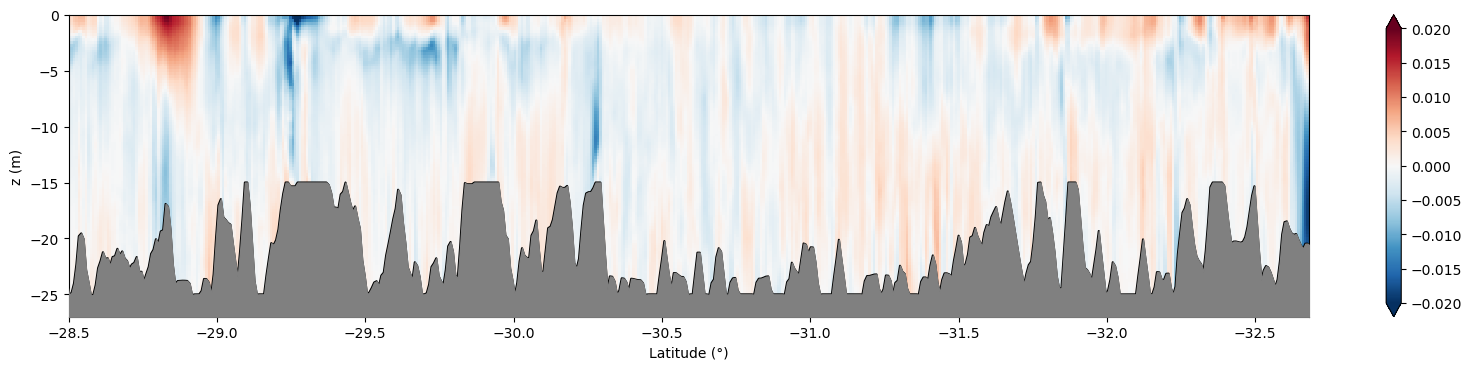

In [55]:
plt.figure(figsize=(20,4), facecolor='w', dpi=100)
(transport*3600*24).mean('time').rolling({'eta_rho':2}, center=True).mean().plot(x='lat_rho', vmin=-0.02, vmax=0.02, cmap='RdBu_r', cbar_kwargs={'label':''})
ax = plt.gca()
ax.fill_between(cs.lat_rho,-y.rolling({'eta_rho':3},center=True).mean().values,-27, zorder=3, color='grey')
ax.plot(cs.lat_rho, -y.rolling({'eta_rho':3},center=True).mean().values, color='k')
ax.set_title('')
ax.set_ylabel('z (m)')
ax.set_xlabel('Latitude (°)')
ax.set_ylim(-27,0)
ax.set_xlim(-28.5,-32.68)

(-25.0, 0.0)

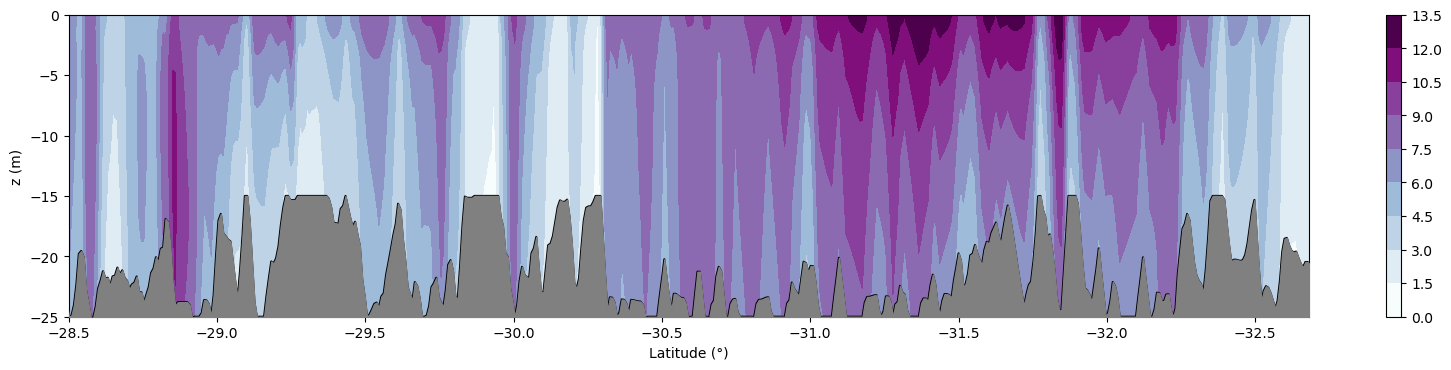

In [62]:
plt.figure(figsize=(20,4), facecolor='w', dpi=100)
(100*cs).rolling({'eta_rho':3}, center=True).mean().plot.contourf(x='lat_rho', levels=10, cmap='BuPu', cbar_kwargs={'label':''})
ax = plt.gca()
ax.fill_between(cs.lat_rho,-y.rolling({'eta_rho':3},center=True).mean().values,-27, zorder=3, color='grey')
ax.plot(cs.lat_rho, -y.rolling({'eta_rho':3},center=True).mean().values, color='k')
ax.set_title('')
ax.set_ylabel('z (m)')
ax.set_xlabel('Latitude (°)')
ax.set_xlim(-28.5,-32.68)
ax.set_ylim(-25,0)
